In [117]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [118]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [119]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("B:/tut-pricing-model/amazon_sa/amazon_sa/spiders/tint.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["title"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["title", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["title", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df["title"].str.contains("Lip gloss|Lip Gloss|Lip Balm|Lip balm|Blackout|Eyebrow|Foundation|BB|Sunscreen|Window|Car", na=False)]
print(df)


                                                 title       price  \
160  100% PURE Lip & Cheek Tint (Fruit Pigmented), ...  SAR 152.81   
230  12 by 48 Inches Self Adhesive Headlight, Tail ...   SAR 60.00   
296  3Pcs Fruit Hydrating Glaze Lip Glow Oil Gloss ...   SAR 39.99   
243  4 in 1 Makeup Brush Set, Travel Multifunctiona...   SAR 53.99   
132  ALMEKAQUZ Lip Marker Stain Pen Set,Longlasting...   SAR 42.66   
..                                                 ...         ...   
377  immetee Lace Tint Mousse for Wigs, Wig Tint La...   SAR 35.00   
110  rom&nd Glasting Melting Balm 3.5g, 02 LOVEY PI...   SAR 43.95   
195  rom&nd Radiant Water Glow 2 Colours | Syrupy S...   SAR 49.00   
332     voloria I'm Tattoo Velvet Tint, 05 - Coral Red   SAR 15.00   
205  wet n wild Bare Focus Skin Tint, 5% Niacinamid...   SAR 67.70   

                 rating                                               link  \
160  4.1 out of 5 stars  https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...   
230

In [120]:
import pandas as pd
from difflib import SequenceMatcher
def is_tint_related(name):
    name = str(name).lower()
    keywords = ['lip tint', 'cheek tint', 'tint', 'blush tint']
    for keyword in keywords:
        if keyword in name or SequenceMatcher(None, keyword, name).ratio() > 0.7:
            return True
    return False
df = df[df['title'].apply(is_tint_related)]
df.reset_index(drop=True, inplace=True)

In [121]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df["title"].apply(is_multi_item)

# Split the DataFrame
sets_df = df[mask_sets].copy()
df = df[~mask_sets].copy()

# Optional: Reset index if needed
sets_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [122]:
# Only compute if both volume and price are available
"""df["volume_per_price"] = df.apply(
    lambda row: row["volume"] / row["price_numeric"]
    if pd.notna(row["volume"]) and pd.notna(row["price_numeric"]) and row["price_numeric"] > 0
    else None,
    axis=1
)"""


'df["volume_per_price"] = df.apply(\n    lambda row: row["volume"] / row["price_numeric"]\n    if pd.notna(row["volume"]) and pd.notna(row["price_numeric"]) and row["price_numeric"] > 0\n    else None,\n    axis=1\n)'

In [123]:
print(df["price_numeric"].describe())


count    131.000000
mean      58.482977
std       38.996316
min       11.240000
25%       30.000000
50%       47.850000
75%       74.495000
max      225.380000
Name: price_numeric, dtype: float64


In [124]:
#print(df["volume_per_price"].describe())


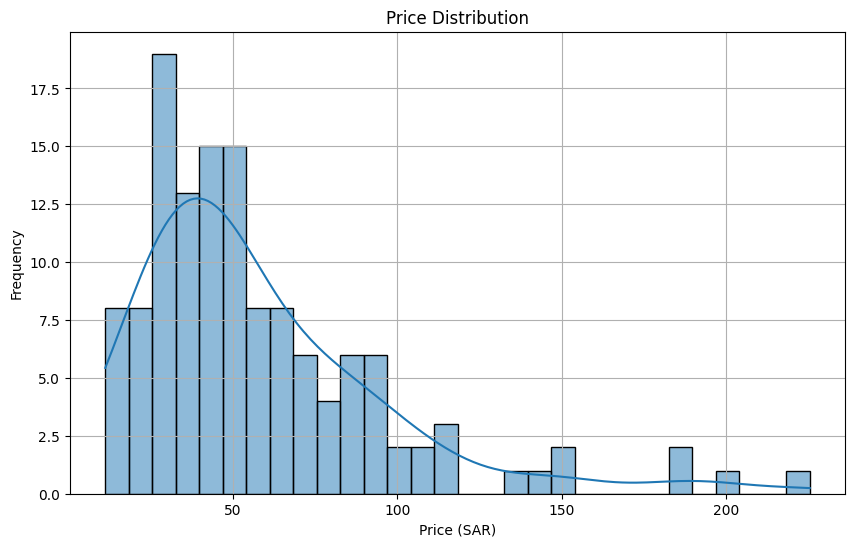

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [126]:
df_cleaned = df.dropna(subset=["title", "price_numeric"])
df_cleaned.shape

(131, 7)

In [127]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned["price_log"] = np.log1p(df_cleaned["price_numeric"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


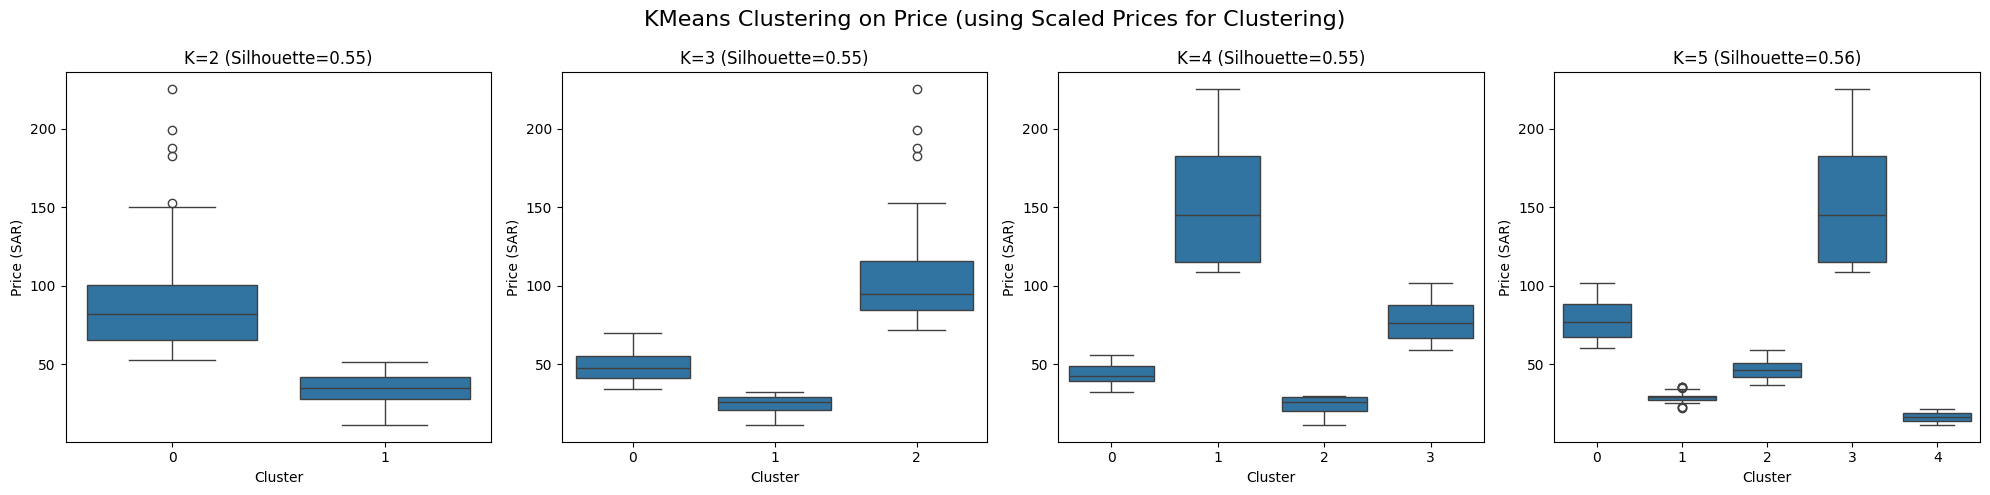

In [128]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


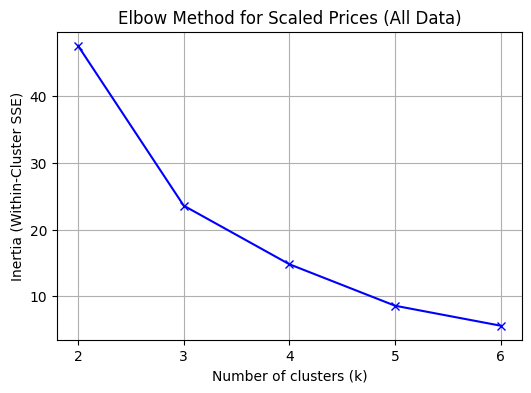

In [129]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [162]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Reassign cluster labels based on ascending mean price
df_cleaned = df_cleaned.copy()
df_cleaned["temp_cluster"] = kmeans.labels_

# Calculate mean price per cluster
cluster_means = (
    df_cleaned.groupby("temp_cluster")["price_numeric"]
    .mean()
    .sort_values()
    .reset_index()
)

# Create a mapping from original label to sorted label (e.g. {2: 0, 0: 1, 1: 2})
label_mapping = {row["temp_cluster"]: new_label for new_label, row in cluster_means.iterrows()}

# Apply new labels
df_cleaned["final_cluster"] = df_cleaned["temp_cluster"].map(label_mapping)
df_cleaned.drop(columns=["temp_cluster"], inplace=True)

# 4. Show actual price statistics per sorted cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["price_numeric"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean    min     max
final_cluster                                  
0                 35   24.084857  11.24   32.31
1                 61   48.960328  33.99   70.00
2                 35  109.477714  72.00  225.38


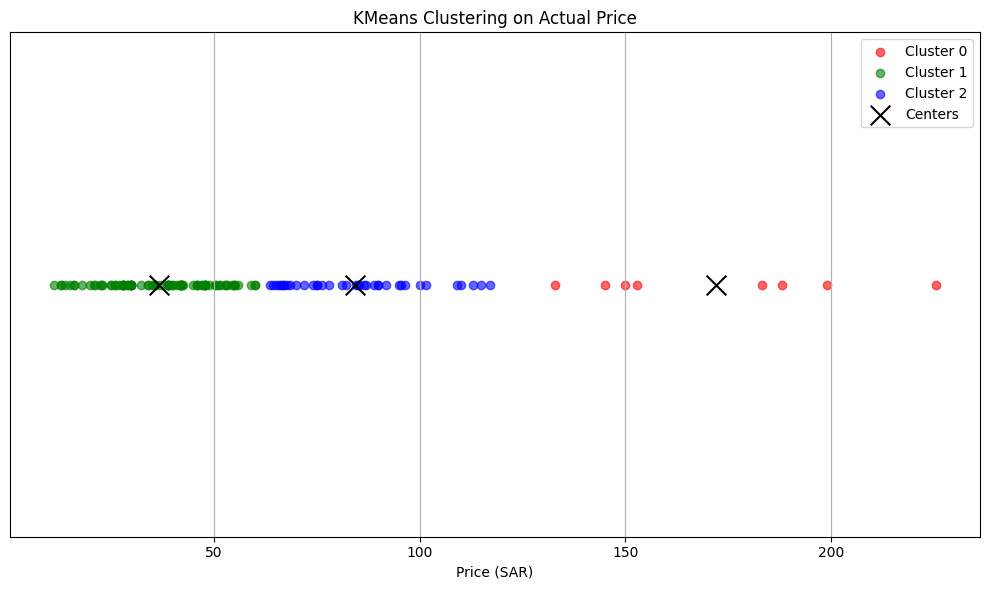

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Make sure 'price_numeric' exists in df_cleaned
df_cleaned = df_cleaned.copy()

# Prepare actual price data
X_price = df_cleaned[["price_numeric"]].values

# Run KMeans on actual prices
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)
df_cleaned["final_cluster"] = kmeans.labels_

# Plotting clusters based on actual price
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for cluster in range(k):
    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]
    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),
                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])

# Cluster centers (actual price values)
centers = kmeans.cluster_centers_.flatten()
plt.scatter(centers, [0] * k, c='black', s=200, marker='x', label='Centers')

# Plot config
plt.title("KMeans Clustering on Actual Price")
plt.xlabel("Price (SAR)")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [163]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == 0)
]
low

,title,price,rating,link,price_numeric,rating_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
5,"Azonee 2 Pcs Lip Stain Tint Set, Mini Liquid L...",SAR 29.99,2.1 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,29.99,2.1,7.0,3.433665,-0.799274,1,1,2,1,0
8,Azonee Matte Liquid Blush Wand - Velvety Cheek...,SAR 27.99,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,27.99,NaN,25.0,3.366951,-0.911871,1,1,2,1,0
16,"Cream Blush stick, 2-in-1 Cheek Blush & Lip Ti...",SAR 28.00,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,28.00,NaN,NaN,3.367296,-0.911289,1,1,2,1,0
20,Daroge Bene Tint Dg0034,SAR 22.99,5.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,22.99,5.0,NaN,3.177637,-1.231389,1,1,2,1,0
23,ETUDE Dear Darling Water Tint #5 Grape Ade | V...,SAR 11.24,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,11.24,4.0,NaN,2.504709,-2.367134,1,1,2,4,0
25,ETUDE HOUSE Dear Darling Water Tint - Strawber...,SAR 26.00,4.1 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,26.00,4.1,NaN,3.295837,-1.031895,1,1,2,1,0
27,Essence Tinted Kiss Hydrating Lip Tint 03,SAR 25.00,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,25.00,4.0,NaN,3.258097,-1.095592,1,1,2,1,0
28,Essence Tinted Kiss Hydrating Lip Tint 102,SAR 16.00,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,16.00,3.8,NaN,2.833213,-1.812696,1,1,2,4,0
29,Essence Tinted Kiss Hydrating Lip Tint 106,SAR 16.00,3.6 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,16.00,3.6,NaN,2.833213,-1.812696,1,1,2,4,0
30,Essence Tinted Kiss Hydrating Lip Tint 107,SAR 25.00,4.1 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,25.00,4.1,NaN,3.258097,-1.095592,1,1,2,1,0


In [164]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
mid

,title,price,rating,link,price_numeric,rating_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1,"12 by 48 Inches Self Adhesive Headlight, Tail ...",SAR 60.00,3.7 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,60.00,3.7,NaN,4.110874,0.343697,0,0,3,0,1
2,3Pcs Fruit Hydrating Glaze Lip Glow Oil Gloss ...,SAR 39.99,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,39.99,4.0,NaN,3.713328,-0.327267,1,0,0,2,1
3,"ALMEKAQUZ Lip Marker Stain Pen Set,Longlasting...",SAR 42.66,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,42.66,NaN,NaN,3.776432,-0.220762,1,0,0,2,1
6,"Azonee 6 Colors Lip Tint Stain Set, Mini Liqui...",SAR 45.99,5.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,45.99,5.0,NaN,3.849935,-0.096707,1,0,0,2,1
7,"Azonee Blush Palette, 4 Colors Cool Purple Lav...",SAR 41.78,1.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,41.78,1.0,NaN,3.756071,-0.255128,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,"The Face Shop Water Fit Lip Tint 5 g, 03 Picni...",SAR 68.59,4.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,68.59,4.2,NaN,4.242621,0.566055,0,0,3,0,1
120,"The Face Shop Water Fit Lip Tint Cherry Kiss, ...",SAR 66.71,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,66.71,4.0,NaN,4.215234,0.519832,0,0,3,0,1
124,"Yadah Be My Tint 4 g, 03 Real Red",SAR 53.20,1.7 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,53.20,1.7,NaN,3.992681,0.144215,0,0,0,2,1
128,"immetee Lace Tint Mousse for Wigs, Wig Tint La...",SAR 35.00,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,35.00,4.0,150.0,3.583519,-0.546355,1,0,0,1,1


In [165]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
high

,title,price,rating,link,price_numeric,rating_numeric,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,"100% PURE Lip & Cheek Tint (Fruit Pigmented), ...",SAR 152.81,4.1 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,152.81,4.1,7.689110,5.035718,1.904618,0,2,1,3,2
4,Anastasia Beverly Hills - Beauty Balm Serum Bo...,SAR 225.38,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,225.38,3.8,NaN,5.422215,2.556934,0,2,1,3,2
9,Benefit Bene Tint Rose Tinted Lip & Cheek Stain,SAR 145.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,145.00,4.3,NaN,4.983607,1.816666,0,2,1,3,2
10,Benefit Benetint Lip&Cheek Stain 6Ml,SAR 90.00,4.2 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,90.00,4.2,6.000000,4.510860,1.018779,0,2,3,0,2
11,Benefit Gogotint,SAR 86.60,3.8 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,86.60,3.8,NaN,4.472781,0.954512,0,2,3,0,2
12,Benefit Lovetint Fiery-Red Tinted Lip & Cheek ...,SAR 74.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,74.00,4.3,6.000000,4.317488,0.692414,0,2,3,0,2
13,Benefit Rose-tinted Cheek & lip Stain (Travel ...,SAR 183.04,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,183.04,4.3,4.000000,5.215153,2.207462,0,2,1,3,2
22,ETUDE Dear Darling Water Tint #4 Red Grapefrui...,SAR 85.00,4.0 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,85.00,4.0,NaN,4.454347,0.923400,0,2,3,0,2
24,ETUDE Fixing Tint #05 Midnight Mauve| Long Las...,SAR 89.00,4.3 out of 5 stars,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,89.00,4.3,NaN,4.499810,1.000130,0,2,3,0,2
26,ETUDE [ House] Dear Darling Water Gel Tint 4.5...,SAR 72.00,None,https://www.amazon.sa/-/en/sspa/click?ie=UTF8&...,72.00,NaN,NaN,4.290459,0.646795,0,2,3,0,2


KMeans clusters: 3
DBSCAN clusters: 9 (+ noise)


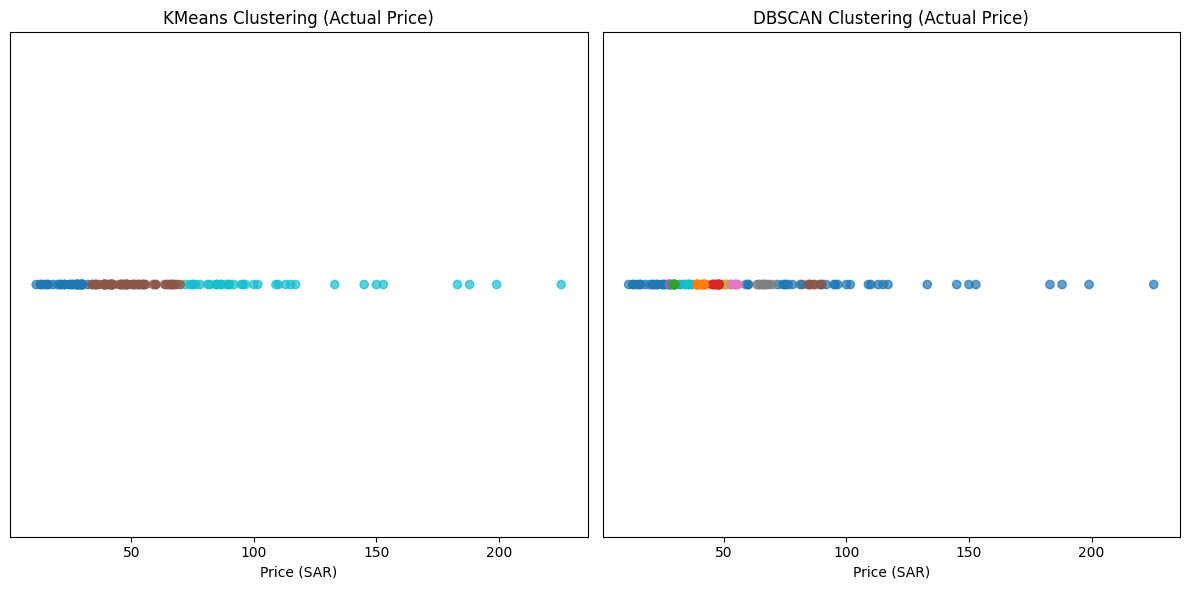

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Run DBSCAN on existing scaled price
dbscan = DBSCAN(eps=0.05, min_samples=5)
df_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])

# 2. Compare number of clusters
n_kmeans = df_cleaned["final_cluster"].nunique()
n_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)

print(f"KMeans clusters: {n_kmeans}")
print(f"DBSCAN clusters: {n_dbscan} (+ noise)")

# 3. Visual comparison
plt.figure(figsize=(12, 6))

# KMeans plot
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["dbscan_cluster"], cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

plt.tight_layout()
plt.show()
"""

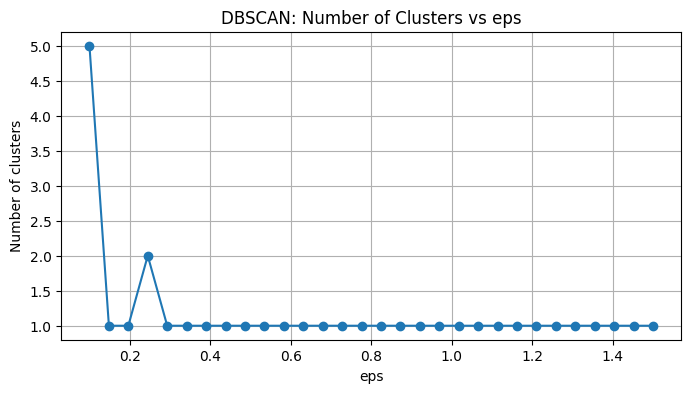

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

eps_values = np.linspace(0.1, 1.5, 30)
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_cleaned[["price_scaled"]])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("DBSCAN: Number of Clusters vs eps")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid(True)
plt.show()
"""